# imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import torch
import warnings
import pytz
from datetime import datetime, time
from zoneinfo import ZoneInfo
from collections import deque
import os

from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

from gymnasium.envs.registration import register
from simglucose.simulation.scenario import CustomScenario

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
warnings.filterwarnings("ignore")

print("hi")
from src.wrappers import ActionclipWrapper, FeatureWrapper, StackObsWrapper
from src.make_environment import make_env, make_env_stacked, make_env_stacked_for_patient
from src.reward_function import improved_reward
from src.utils import * 
print("import done")

hi
import done


# gymnasium set up 

In [10]:
start_time = datetime.combine(datetime.today(), time(6,0))    # starting at 6 am of today
# Meal schedule (time offset from 6 a.m., carbs in grams):
# (1, 45)   → 7:00 AM   breakfast
# (6, 70)   → 12:00 PM  lunch
# (10, 15)  → 4:00 PM   snack
# (12, 80)  → 6:00 PM   dinner
# (17, 10)  → 11:00 PM   snack
scenario  = CustomScenario(start_time=start_time, scenario=[(1, 45), (6, 70), (10, 15), (12, 80), (17, 10)])


register(
    id="simglucose/adult1-debug-v0",
    entry_point="simglucose.envs:T1DSimGymnaisumEnv",
    max_episode_steps=480,                  # 480 steps, each step is 3 minutes
                                            # 3 x 480 = 1440 minutes ---> 24 hour simulation
    kwargs={"patient_name": "adult#001",        #training on adult #1 only
            "reward_fun": improved_reward,      # reward function
            "custom_scenario": scenario,        # pass deterministic random scenario
    },
)

# Load existing models here

In [60]:
# ---------- Vanilla ----------
env = make_env(seed=SEED)
model = PPO("MlpPolicy", env, verbose=0)

state_dict = torch.load(
    "vanilla_policy_state_dict.pt",
    map_location="cpu",
)
model.policy.load_state_dict(state_dict)


# ---------- Stacked ----------
env = make_env_stacked(seed=SEED, k=4)
model_stacked = PPO("MlpPolicy", env, verbose=0)

state_dict = torch.load(
    "stacked_policy_state_dict.pt",
    map_location="cpu",
)
model_stacked.policy.load_state_dict(state_dict)


<All keys matched successfully>

# random insluin baselin 


--- Summary ---
Steps survived: 105  (315 min, 5.25 hours)

Time In Range   (70–180 mg/dL): 56.19%
Time Below Range (<70 mg/dL):   43.81%
Time Above Range (>180 mg/dL):  0.00%


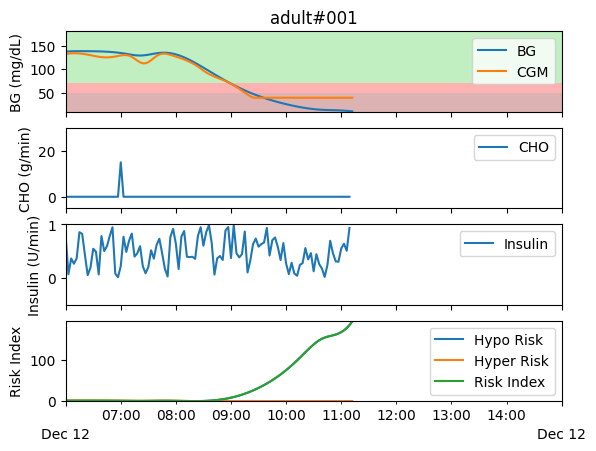

In [6]:
env = make_env(seed=SEED, render=True)
random_policy = lambda obs: env.action_space.sample()
stats_random = display_episode(env, random_policy)

# zero insulin baseline 


--- Summary ---
Steps survived: 480  (1440 min, 24.00 hours)

Time In Range   (70–180 mg/dL): 8.33%
Time Below Range (<70 mg/dL):   0.00%
Time Above Range (>180 mg/dL):  91.67%


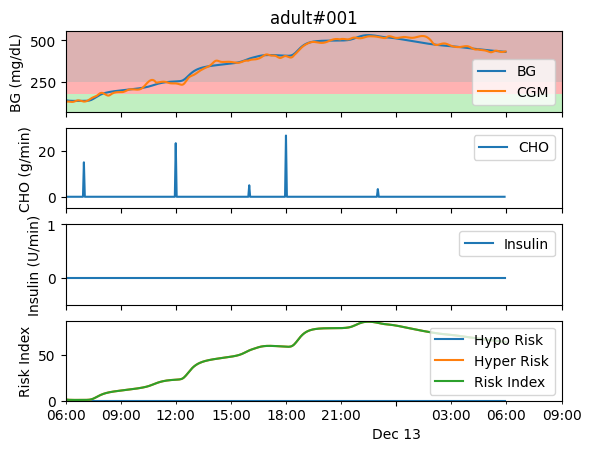

In [10]:
env = make_env(seed=SEED, render=True)
zero_policy = lambda obs: np.array([0.0], dtype=np.float32)
stats_zero = display_episode(env, zero_policy)


# Baseline PPO

Action mean/std/min/max: 0.11948071391164482 0.06140948447975224 0.04876433312892914 0.24668429791927338
corr(CGM, action): 0.9976363800237281

Episode reward mean/std: -313.9360620044236 0.0


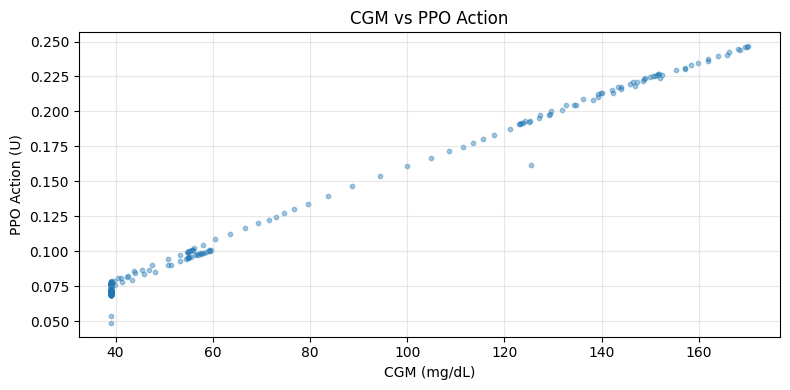

In [6]:
# base
cgms_b, acts_b, ep_returns_b = eval_and_plot_policy(model,make_env, n_episodes=1)


===== Simulation Stats =====
Mean BG             : 65.550
Min BG              : 9.312
Max BG              : 156.006
TIR (%)             : 34.632
TBR (%)             : 65.368
TAR (%)             : 0.000
Total Insulin       : 28.302
Total Reward        : -283.467


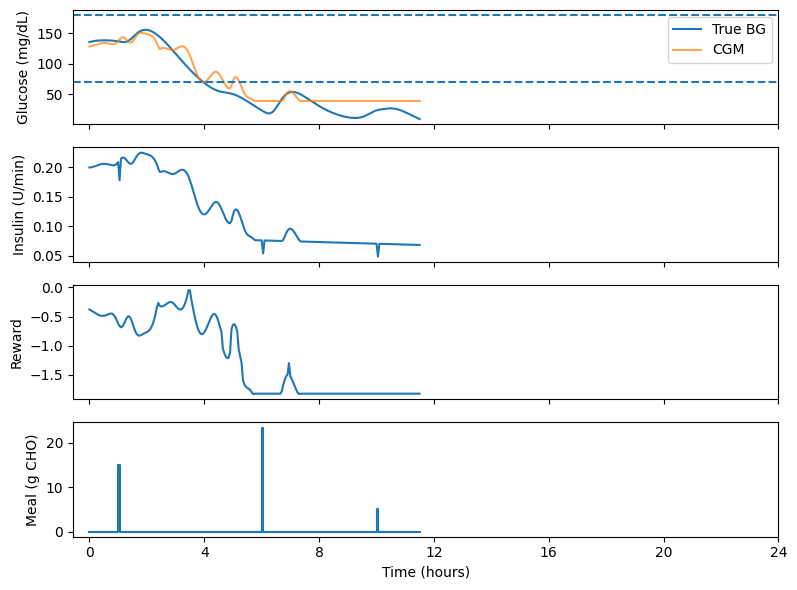

In [19]:
stats_base = rollout_and_plot_day(model,make_env)

t=0, BG=139.90867961569157, reward=-0.3888917926446928, action=[0.19990584]
t=1, BG=140.09378098814844, reward=-0.3861319828561094, action=[0.19998713]
t=2, BG=140.06220316941318, reward=-0.36624503945468806, action=[0.20005563]
t=3, BG=139.9230257116393, reward=-0.3390917170755578, action=[0.19925632]
t=4, BG=139.73904036194895, reward=-0.3123460895112661, action=[0.1977706]
t=5, BG=139.54462807903283, reward=-0.2930873147258899, action=[0.19609758]
t=6, BG=139.35690435550634, reward=-0.2880327068426261, action=[0.19469136]
t=7, BG=139.18263855992612, reward=-0.3036824815049889, action=[0.1939789]
t=8, BG=139.02252670488232, reward=-0.3451499913598277, action=[0.19436936]
t=9, BG=138.8738117335924, reward=-0.41013054308820446, action=[0.1962077]
t=10, BG=138.73187569837455, reward=-0.4862065315012167, action=[0.1995131]
t=11, BG=138.59119493483598, reward=-0.5603113433644463, action=[0.20376304]
t=12, BG=138.4459025024676, reward=-0.6197904942257194, action=[0.20820741]
t=13, BG=138.2

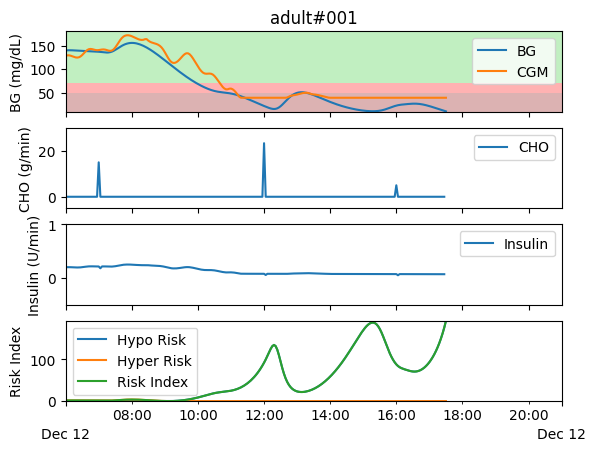

In [9]:
env = make_env(seed=SEED, render=True)
stats_ppo = display_episode(env, model, verbose=True)

# Stacked PPO 

Action mean/std/min/max: 0.06669148329334955 0.07018759426185457 0.0 0.2400481104850769
corr(CGM, action): 0.7737032496273479

Episode reward mean/std: -551.7455887079641 0.0


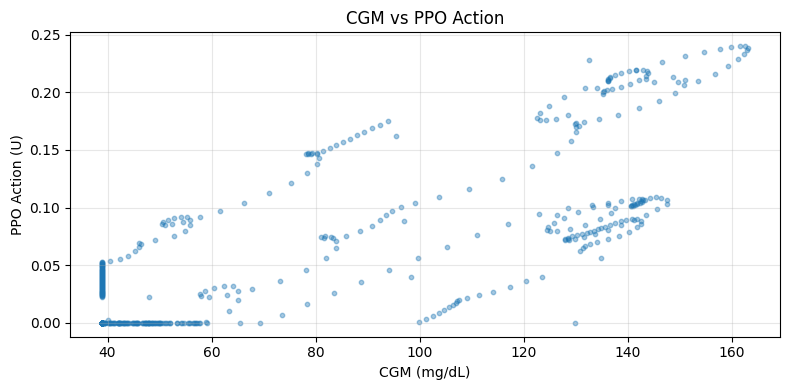

In [22]:
cgms_s, acts_s, ep_returns_s = eval_and_plot_policy(model_stacked,lambda: make_env_stacked(k=4), n_episodes=1)


===== Simulation Stats =====
Mean BG             : 81.052
Min BG              : 9.956
Max BG              : 162.468
TIR (%)             : 42.920
TBR (%)             : 57.080
TAR (%)             : 0.000
Total Insulin       : 31.879
Total Reward        : -543.491


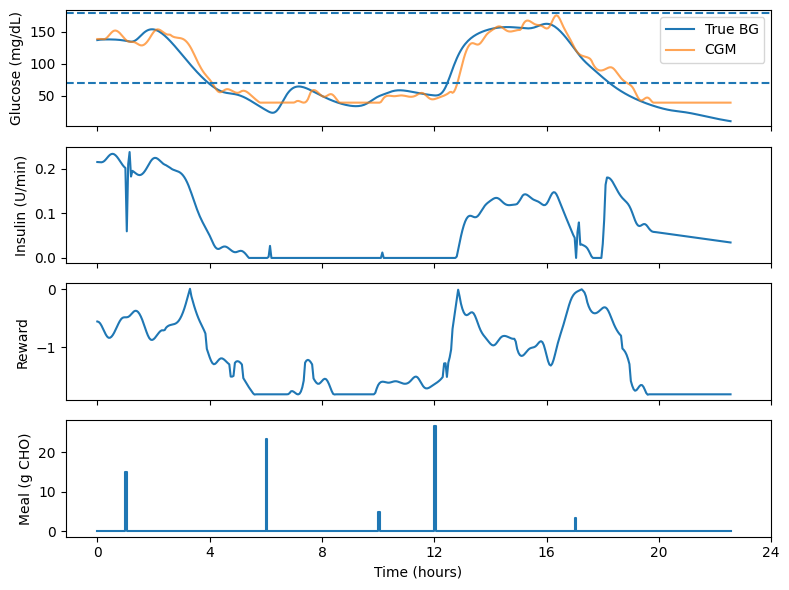

In [28]:
stats_stacked = rollout_and_plot_day(model_stacked, lambda: make_env_stacked(k=4))

t=0, BG=136.3334454522443, reward=-0.24664214345528473, action=[0.18325734]
t=1, BG=137.42757235631132, reward=-0.2901908683062683, action=[0.18358675]
t=2, BG=138.27848020096334, reward=-0.3282879365453757, action=[0.18490544]
t=3, BG=138.93956168573158, reward=-0.3641229240236269, action=[0.18671697]
t=4, BG=139.45159303493253, reward=-0.39675583150273647, action=[0.18930352]
t=5, BG=139.84565701171195, reward=-0.42504713116847703, action=[0.19236416]
t=6, BG=140.1453186802734, reward=-0.4477026259817961, action=[0.19500837]
t=7, BG=140.36827080007004, reward=-0.46330734403252627, action=[0.19728923]
t=8, BG=140.52759520502238, reward=-0.4706399759710448, action=[0.19910133]
t=9, BG=140.6327413966717, reward=-0.4700872993411819, action=[0.20033473]
t=10, BG=140.6902937776885, reward=-0.46428497532930463, action=[0.2009204]
t=11, BG=140.7045788663741, reward=-0.45596644851710894, action=[0.20087978]
t=12, BG=140.67815004283244, reward=-0.4477324965727671, action=[0.20031255]
t=13, BG=

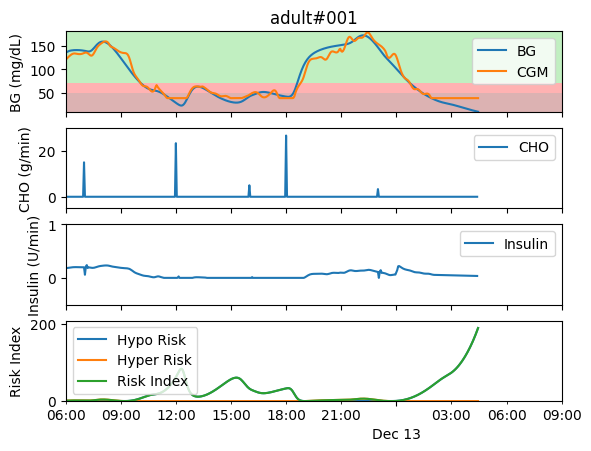

In [29]:
env = make_env_stacked(k=4, seed=SEED, render=True)
stats_ppo_stacked = display_episode(env, model_stacked, verbose=True)

# EVAL survival time

In [ ]:
# PPO (vanilla)
ppo_lengths = evaluate_survival( "ppo", make_env_fn=make_env, model=model)

# PPO (stacked)
stacked_ppo_lengths = evaluate_survival( "stacked ppo", make_env_fn=lambda: make_env_stacked(k=4), model=model_stacked)

# Random
rand_lengths = evaluate_survival( "random", make_env_fn=make_env)

# Constant  0.3 u / min
const_03 = evaluate_survival( "constant",  make_env_fn=make_env, const_action=0.3)

# Constant  0.2 u / min
const_02 = evaluate_survival("constant", make_env_fn=make_env, const_action=0.2)

# Constant  0.1 u / min
const_01 = evaluate_survival( "constant", make_env_fn=make_env, const_action=0.1)

# Constant  0.08 u / min
const_008 = evaluate_survival( "constant", make_env_fn=make_env, const_action=0.08)

# Constant  0.07 u / min
const_007 = evaluate_survival( "constant", make_env_fn=make_env, const_action=0.07)


=== Survival results: PPO ===
Episodes: 20
Mean steps: 231.0 (693.0 min, 11.55 hours)
Std steps:  0.7
Min steps:  229
Max steps:  232

=== Survival results: STACKED PPO ===
Episodes: 20
Mean steps: 464.9 (1394.6 min, 23.24 hours)
Std steps:  12.3
Min steps:  441
Max steps:  480

=== Survival results: RANDOM ===
Episodes: 20
Mean steps: 103.2 (309.5 min, 5.16 hours)
Std steps:  3.9
Min steps:  88
Max steps:  107

=== Survival results: CONSTANT (CONST=0.3) ===
Episodes: 20
Mean steps: 116.0 (348.0 min, 5.80 hours)
Std steps:  0.0
Min steps:  116
Max steps:  116

=== Survival results: CONSTANT (CONST=0.2) ===
Episodes: 20
Mean steps: 174.0 (522.0 min, 8.70 hours)
Std steps:  0.0
Min steps:  174
Max steps:  174

=== Survival results: CONSTANT (CONST=0.1) ===
Episodes: 20
Mean steps: 242.0 (726.0 min, 12.10 hours)
Std steps:  0.0
Min steps:  242
Max steps:  242

=== Survival results: CONSTANT (CONST=0.08) ===
Episodes: 20
Mean steps: 366.0 (1098.0 min, 18.30 hours)
Std steps:  0.0
Min step

# Cross patient generalization test

In [46]:
adult_ids = [f"adult#{i:03d}" for i in range(1, 11)]
adolescent_ids = [f"adolescent#{i:03d}" for i in range(1, 11)]
child_ids = [f"child#{i:03d}" for i in range(1, 11)]


make_env_fn = lambda p: make_env_stacked_for_patient(p, k=4, render=False)

adult_stats      = eval_group(model_stacked, adult_ids, make_env_fn)
adolescent_stats = eval_group(model_stacked, adolescent_ids, make_env_fn)
child_stats      = eval_group(model_stacked, child_ids, make_env_fn)

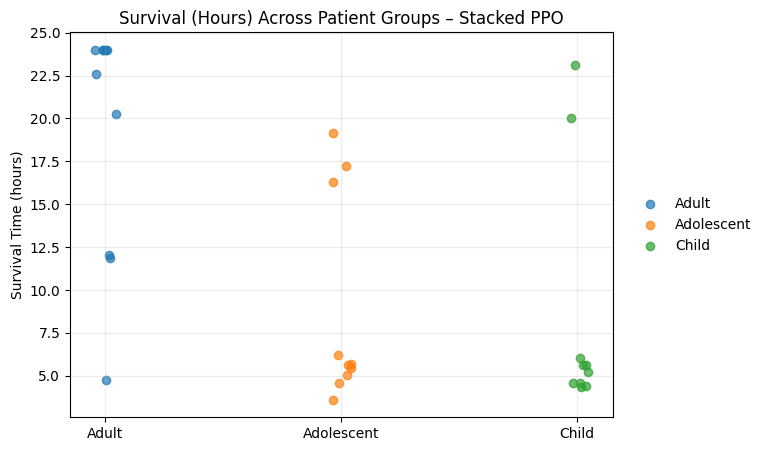

In [47]:
adult_steps  = np.array([s["steps"] for _, s in adult_stats])
adol_steps   = np.array([s["steps"] for _, s in adolescent_stats])
child_steps  = np.array([s["steps"] for _, s in child_stats])

x_adult = np.ones_like(adult_steps) * 0 + np.random.uniform(-0.05, 0.05, len(adult_steps))
x_adol  = np.ones_like(adol_steps)  * 1 + np.random.uniform(-0.05, 0.05, len(adol_steps))
x_child = np.ones_like(child_steps) * 2 + np.random.uniform(-0.05, 0.05, len(child_steps))

# Convert steps → hours
adult_hours = adult_steps * 3 / 60
adol_hours  = adol_steps  * 3 / 60
child_hours = child_steps * 3 / 60

plt.figure(figsize=(7,5))
plt.scatter(x_adult, adult_hours,  alpha=0.7, label="Adult")
plt.scatter(x_adol,  adol_hours,   alpha=0.7, label="Adolescent")
plt.scatter(x_child, child_hours,  alpha=0.7, label="Child")

plt.xticks([0,1,2], ["Adult","Adolescent","Child"])
plt.ylabel("Survival Time (hours)")
plt.title("Survival (Hours) Across Patient Groups – Stacked PPO")
plt.grid(alpha=0.25)
plt.legend( loc="center left", bbox_to_anchor=(1.02, 0.5),  frameon=False )
plt.show()

In [50]:
adult_summary = summarize_group(adult_stats, "Adult")
adol_summary  = summarize_group(adolescent_stats, "Adolescent")
child_summary = summarize_group(child_stats, "Child")


=== Adult (n=10) ===
Mean survival: 383.0 steps (19.15 hours)
TIR%: 48.87 ± 15.69
TBR%: 47.48 ± 12.96
TAR%: 3.65 ± 3.86

=== Adolescent (n=10) ===
Mean survival: 177.6 steps (8.88 hours)
TIR%: 54.96 ± 10.52
TBR%: 40.24 ± 9.81
TAR%: 4.81 ± 6.90

=== Child (n=10) ===
Mean survival: 166.9 steps (8.35 hours)
TIR%: 39.85 ± 15.90
TBR%: 57.57 ± 18.14
TAR%: 2.58 ± 5.39


In [ ]:
summaries = [adult_summary, adol_summary, child_summary]

for s in summaries:
    print(
        f'{s["group"]:>11} | '
        f'steps {s["mean_steps"]:>6.2f} | '
        f'hours {s["mean_hours"]:>6.2f} | '
        f'TIR {s["mean_TIR"]:>4.1f} | '
        f'TBR {s["mean_TBR"]:>4.1f} | '
        f'TAR {s["mean_TAR"]:>4.1f}'
    )

      Adult | steps 383.00 | hours  19.15 | TIR 48.9 | TBR 47.5 | TAR  3.7
 Adolescent | steps 177.60 | hours   8.88 | TIR 55.0 | TBR 40.2 | TAR  4.8
      Child | steps 166.90 | hours   8.35 | TIR 39.8 | TBR 57.6 | TAR  2.6
